In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

In [24]:
train_dir = '/content/drive/MyDrive/plant_disease_dataset/New_Plant_Diseases_Dataset/New_Plant_Diseases_Dataset/train'
test_dir = '/content/drive/MyDrive/plant_disease_dataset/New_Plant_Diseases_Dataset/New_Plant_Diseases_Dataset/valid'

In [25]:
# ImageDataGenerator for training and testing
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.3,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    shear_range=0.3,  # Increased shear
    zoom_range=0.3,  # Increased zoom
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical',shuffle=False)

Found 12895 images belonging to 7 classes.
Found 3224 images belonging to 7 classes.


In [27]:
# Visualize some sample images
def plot_sample_images(generator, class_indices):
    images, labels = next(generator)
    class_labels = list(class_indices.keys()) #for multiclass
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

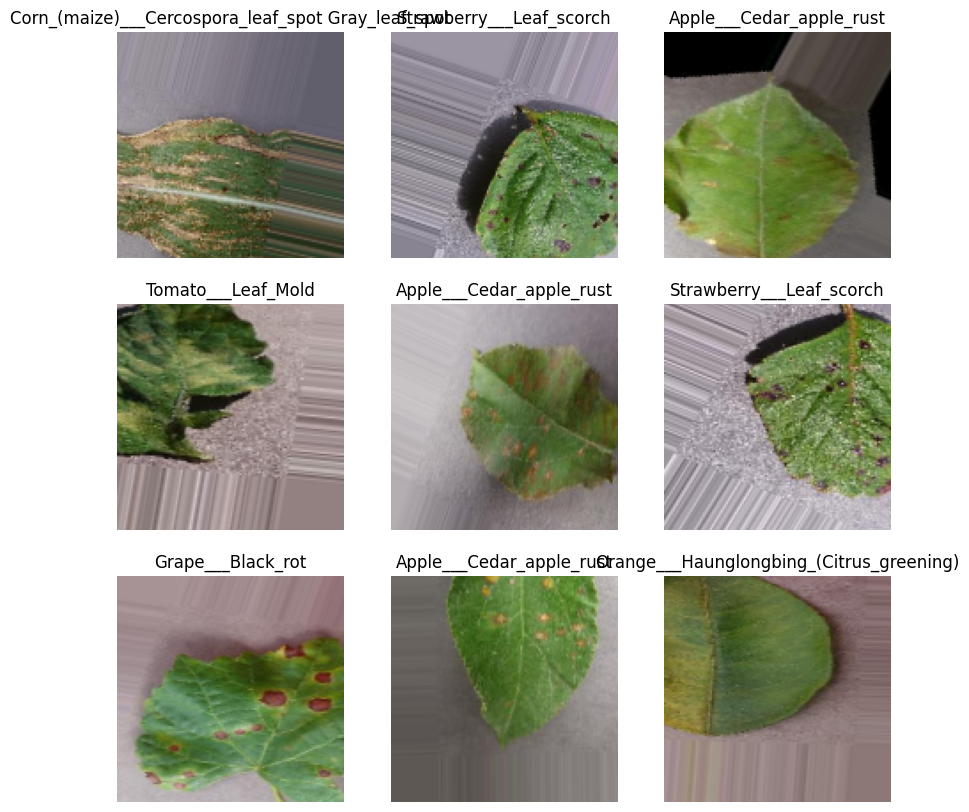

In [28]:
import numpy as np
plot_sample_images(train_generator, train_generator.class_indices)

In [29]:
#calculate and visualize class distribution
import numpy as np
class_counts = np.bincount(train_generator.classes)
print(f"Class Distribution: {class_counts}")


Class Distribution: [1760 1642 1888 2010 1939 1774 1882]


In [30]:
#calculate and visualize class distribution
import numpy as np
class_counts = np.bincount(test_generator.classes)
print(f"Class Distribution: {class_counts}")


Class Distribution: [440 410 472 503 485 444 470]


In [31]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

In [32]:
# CNN model with L2 regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)), #adding regulizers
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,569,095 (5.99 MB)

 Trainable params: 1,569,095 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    class_weight=class_weight_dict,
    #callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.3448 - loss: 1.9205 - val_accuracy: 0.5759 - val_loss: 1.4102
Epoch 2/10
  1/402 ━━━━━━━━━━━━━━━━━━━━ 7:00 1s/step - accuracy: 0.8125 - loss: 0.7342

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.8125 - loss: 0.7342 - val_accuracy: 0.8750 - val_loss: 0.6880
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.7375 - loss: 0.8980 - val_accuracy: 0.7181 - val_loss: 1.1114
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.7812 - loss: 0.5357 - val_accuracy: 0.9167 - val_loss: 0.5331
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.8498 - loss: 0.5946 - val_accuracy: 0.9219 - val_loss: 0.3820
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.4192 - val_accuracy: 0.9583 - val_loss: 0.2042
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.8839 - loss: 0.4725 - val_accuracy: 0.8303 - val_loss: 0.7425
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9062 - loss: 0.3308 - val_accuracy: 0.9167 - val_loss: 0.3915
Epoch 9/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.9138 - loss: 0.3954 - val_accuracy: 0.896

In [36]:
# Step 6: Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 486ms/step - accuracy: 0.8703 - loss: 0.5727
Test Accuracy: 0.9131513833999634


In [37]:
# Predict on the test data
y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 488ms/step


In [38]:
# Classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_class, target_names=class_labels))


Classification Report:
                                                    precision    recall  f1-score   support

                          Apple___Cedar_apple_rust       0.98      0.85      0.91       440
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.80      0.86       410
                                 Grape___Black_rot       0.89      0.93      0.91       472
          Orange___Haunglongbing_(Citrus_greening)       0.99      0.89      0.94       503
                             Potato___Early_blight       0.78      1.00      0.88       485
                          Strawberry___Leaf_scorch       0.92      0.98      0.95       444
                                Tomato___Leaf_Mold       0.96      0.93      0.94       470

                                          accuracy                           0.91      3224
                                         macro avg       0.92      0.91      0.91      3224
                                      weighted avg    

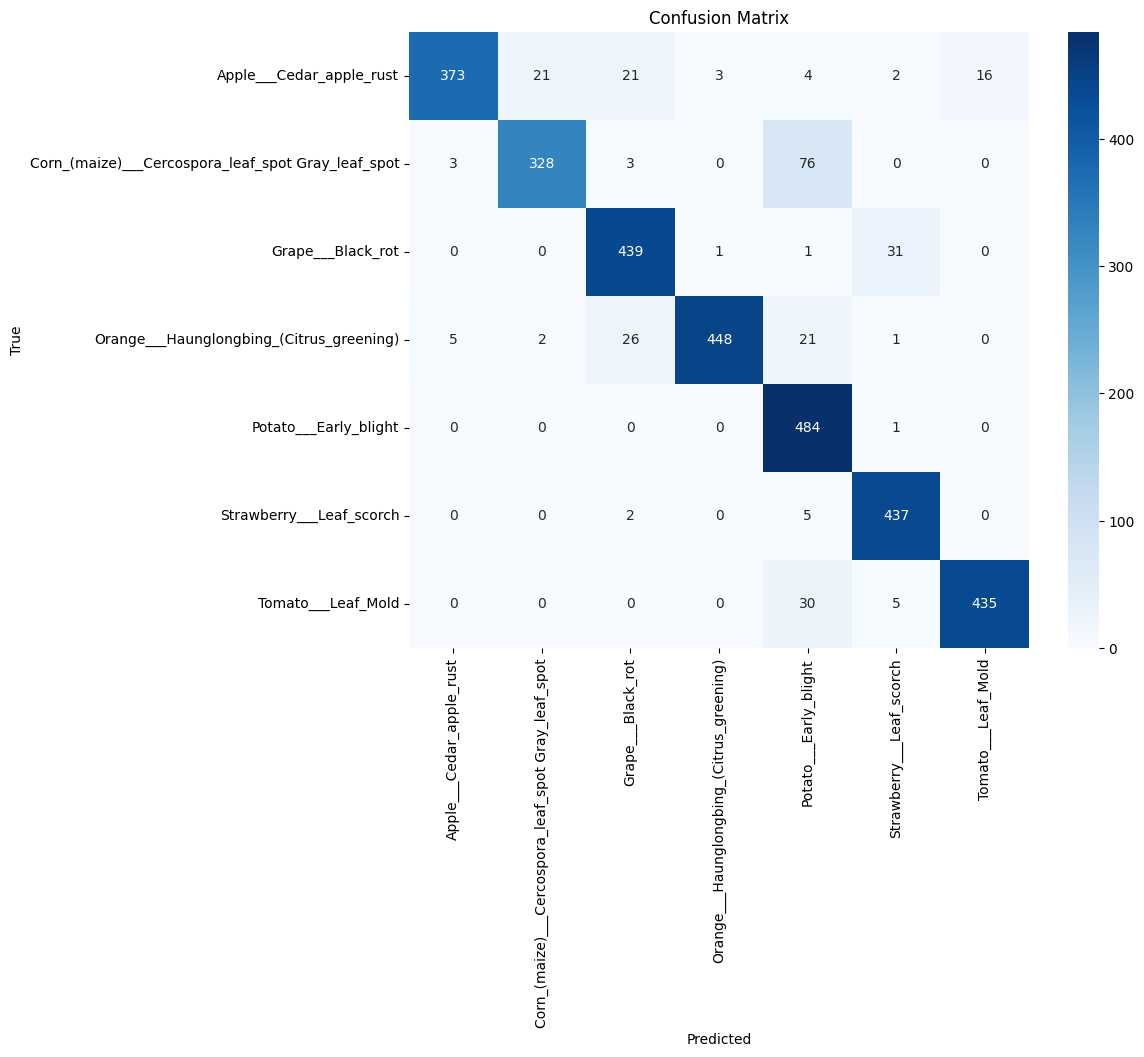

In [39]:
# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class, average='weighted')  # Weighted for multiclass
recall = recall_score(y_true, y_pred_class, average='weighted')
f1 = f1_score(y_true, y_pred_class, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9132
Precision: 0.9220
Recall: 0.9132
F1 Score: 0.9136


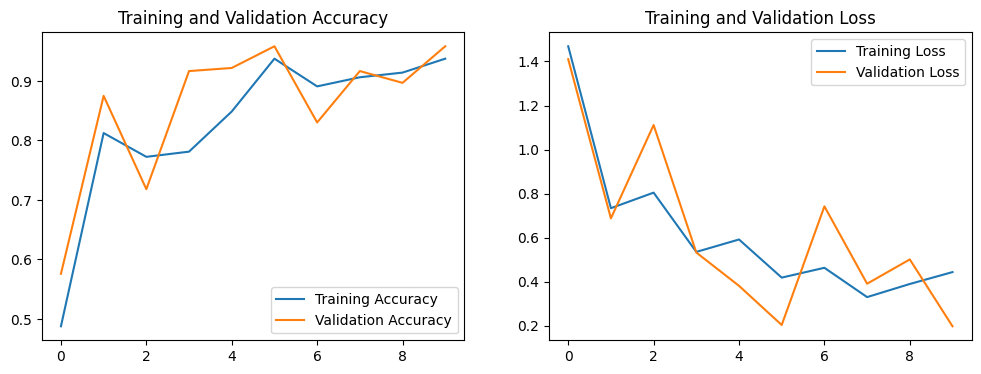

In [41]:
# Plot training and validation accuracy and loss
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_performance(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


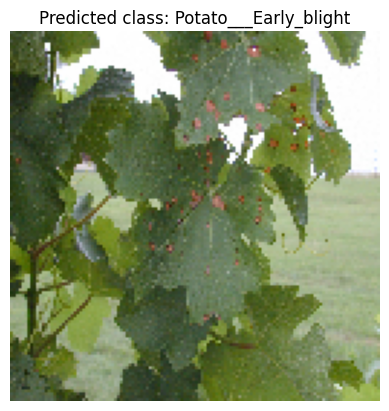

gbl.jpg: Predicted class is Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


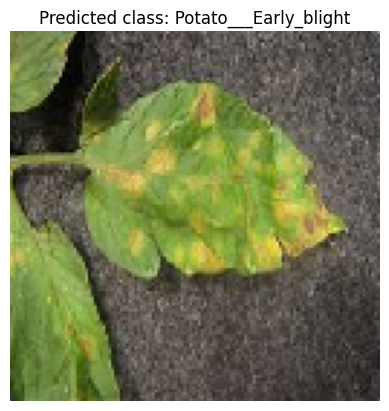

tolm.jpg: Predicted class is Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


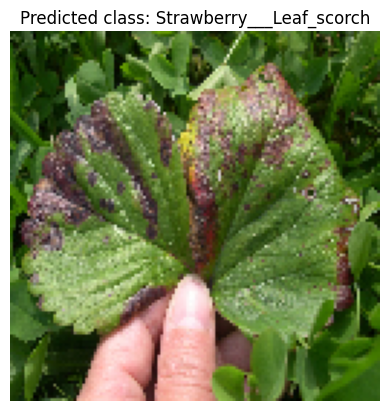

sls.jpg: Predicted class is Strawberry___Leaf_scorch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


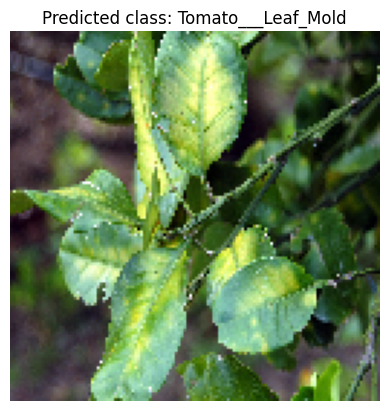

ohii.jpg: Predicted class is Tomato___Leaf_Mold
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


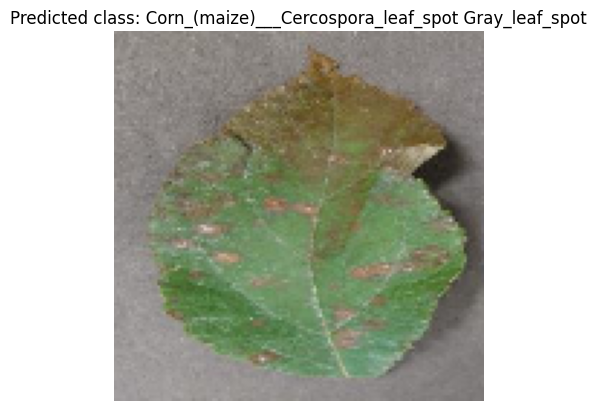

acr.jpg: Predicted class is Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


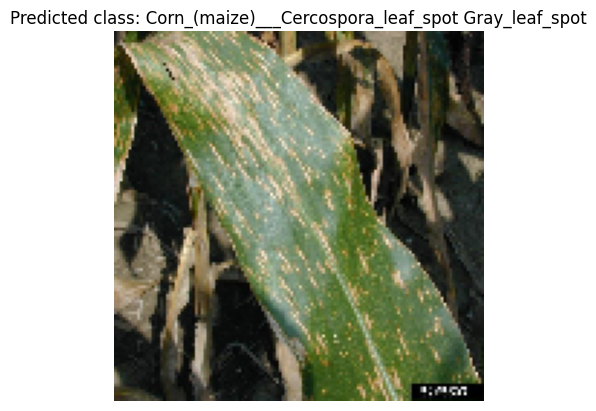

cncls.jpg: Predicted class is Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


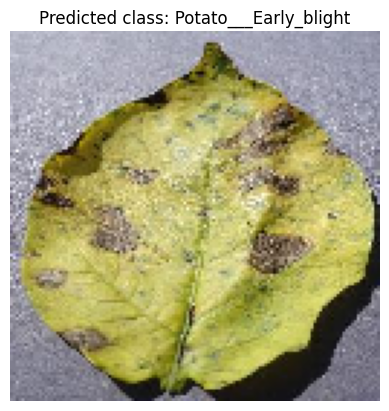

peb.jpg: Predicted class is Potato___Early_blight


In [42]:
# Predict and display results for user-uploaded images
from tensorflow.keras.preprocessing import image

def predict_image(image_path, model, class_indices, display_image=False):
    """
    Predict the class for a given image.

    Args:
        image_path (str): Path to the image file.
        model: Pretrained TensorFlow/Keras model.
        class_indices: Dictionary of class indices.
        display_image (bool): Whether to display the image with the prediction.

    Returns:
        str: Predicted class.
    """
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(prediction)]

    if display_image:
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class}')
        plt.axis('off')
        plt.show()

    return predicted_class

# Example predictions
test_images = ['gbl.jpg', 'tolm.jpg', 'sls.jpg', 'ohii.jpg', 'acr.jpg', 'cncls.jpg', 'peb.jpg']
for img_path in test_images:
    result = predict_image(img_path, model, train_generator.class_indices, display_image=True)
    print(f'{img_path}: Predicted class is {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


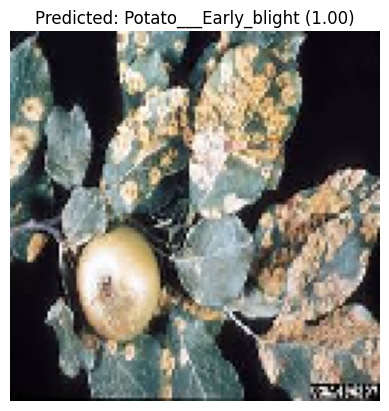

acar.jpg: Predicted class is Potato___Early_blight with confidence score 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


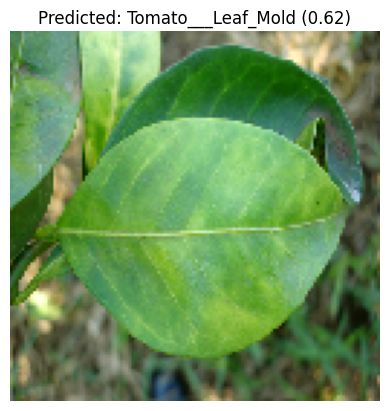

ohc.jpg: Predicted class is Tomato___Leaf_Mold with confidence score 0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


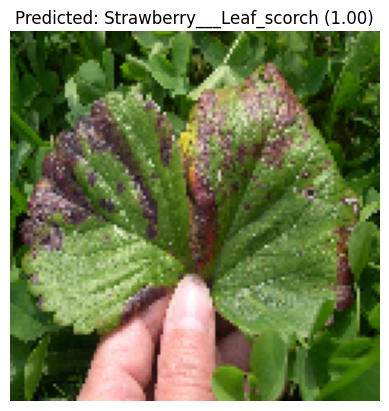

sls.jpg: Predicted class is Strawberry___Leaf_scorch with confidence score 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


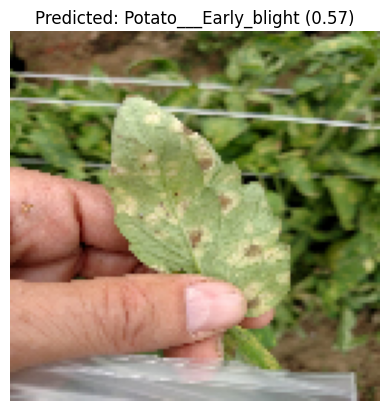

tlm.jpg: Predicted class is Potato___Early_blight with confidence score 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


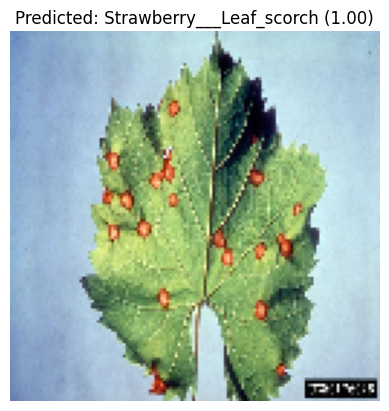

gbr2.jpg: Predicted class is Strawberry___Leaf_scorch with confidence score 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


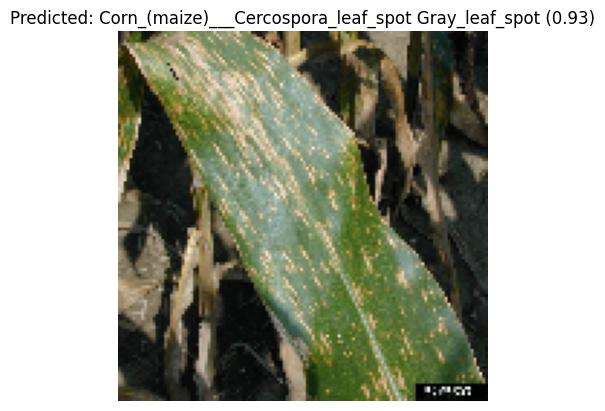

cncls.jpg: Predicted class is Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot with confidence score 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


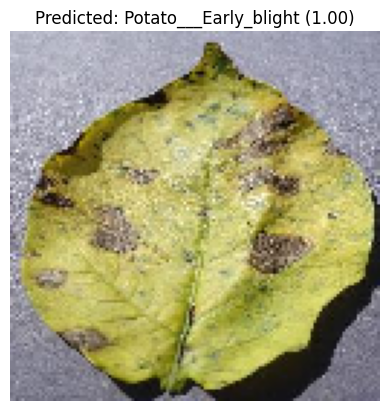

peb.jpg: Predicted class is Potato___Early_blight with confidence score 1.00


In [49]:
from tensorflow.keras.preprocessing import image

def predict_image(image_path, model, class_indices, display_image=False):
    """
    Predict the class for a given image with confidence score.

    Args:
        image_path (str): Path to the image file.
        model: Pretrained TensorFlow/Keras model.
        class_indices: Dictionary of class indices.
        display_image (bool): Whether to display the image with the prediction.

    Returns:
        tuple: Predicted class and confidence score.
    """
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(class_indices.keys())[predicted_class_index]
    confidence_score = prediction[0][predicted_class_index]

    if display_image:
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class} ({confidence_score:.2f})')
        plt.axis('off')
        plt.show()

    return predicted_class, confidence_score

# Example predictions
test_images = ['acar.jpg', 'ohc.jpg', 'sls.jpg', 'tlm.jpg', 'gbr2.jpg', 'cncls.jpg', 'peb.jpg']
for img_path in test_images:
    result, confidence = predict_image(img_path, model, train_generator.class_indices, display_image=True)
    print(f'{img_path}: Predicted class is {result} with confidence score {confidence:.2f}')


In [50]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred_class, target_names=class_labels, output_dict=True)

# Extract F1-scores for each class
f1_scores = {disease: metrics['f1-score'] for disease, metrics in report.items() if disease in class_labels}

# Sort diseases by F1-score
sorted_f1_scores = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)

# Display top three diseases
print("Top 3 diseases the model performs well on:")
for disease, score in sorted_f1_scores[:3]:
    print(f"{disease}: F1-score = {score:.2f}")


Top 3 diseases the model performs well on:
Strawberry___Leaf_scorch: F1-score = 0.95
Tomato___Leaf_Mold: F1-score = 0.94
Orange___Haunglongbing_(Citrus_greening): F1-score = 0.94


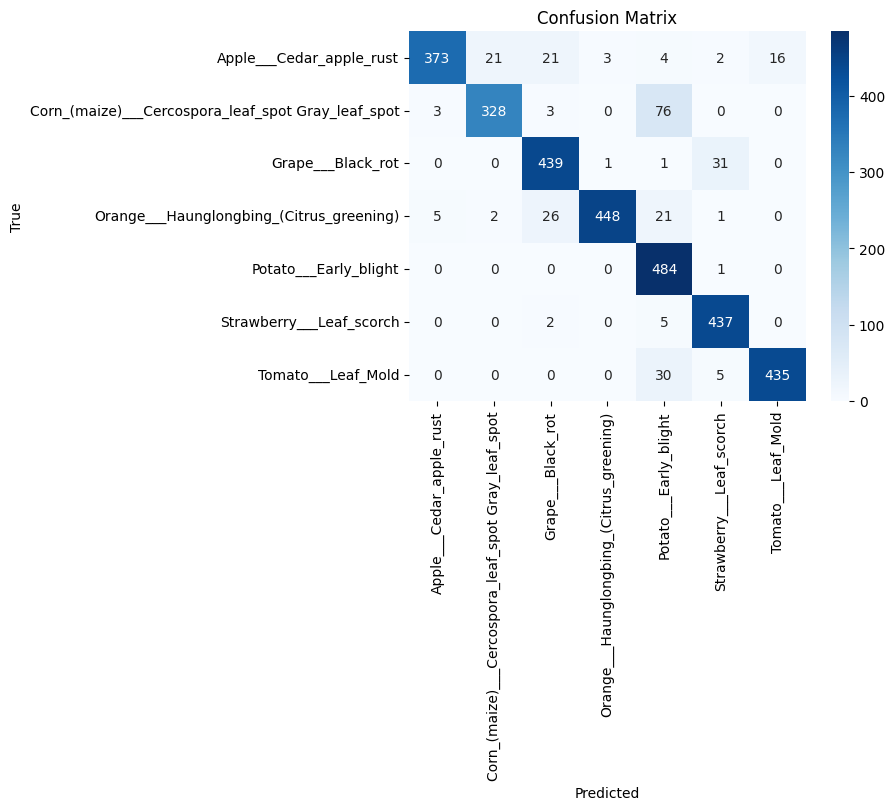

Diseases with high accuracy:
Strawberry___Leaf_scorch: Highly distinguishable features.
Tomato___Leaf_Mold: Highly distinguishable features.
Orange___Haunglongbing_(Citrus_greening): Highly distinguishable features.


In [51]:
# Analyze confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Insights
print("Diseases with high accuracy:")
for disease, score in sorted_f1_scores[:3]:
    print(f"{disease}: Highly distinguishable features.")


In [52]:
# Extract F1-scores for each class
f1_scores = {disease: metrics['f1-score'] for disease, metrics in report.items() if disease in class_labels}

# Sort diseases by F1-score (ascending order)
sorted_f1_scores = sorted(f1_scores.items(), key=lambda x: x[1])

# Display bottom three diseases
print("Bottom 3 diseases the model performs poorly on:")
for disease, score in sorted_f1_scores[:3]:
    print(f"{disease}: F1-score = {score:.2f}")


Bottom 3 diseases the model performs poorly on:
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: F1-score = 0.86
Potato___Early_blight: F1-score = 0.88
Apple___Cedar_apple_rust: F1-score = 0.91


In [53]:
# Analyze misclassified diseases
print("Most common misclassifications:")
for i, row in enumerate(cm):
    if row.sum() > 0:
        misclassified = [(class_labels[j], row[j]) for j in range(len(row)) if i != j and row[j] > 0]
        if misclassified:
            print(f"{class_labels[i]} is often misclassified as:")
            for cls, count in misclassified:
                print(f"  {cls}: {count} times")


Most common misclassifications:
Apple___Cedar_apple_rust is often misclassified as:
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 21 times
  Grape___Black_rot: 21 times
  Orange___Haunglongbing_(Citrus_greening): 3 times
  Potato___Early_blight: 4 times
  Strawberry___Leaf_scorch: 2 times
  Tomato___Leaf_Mold: 16 times
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot is often misclassified as:
  Apple___Cedar_apple_rust: 3 times
  Grape___Black_rot: 3 times
  Potato___Early_blight: 76 times
Grape___Black_rot is often misclassified as:
  Orange___Haunglongbing_(Citrus_greening): 1 times
  Potato___Early_blight: 1 times
  Strawberry___Leaf_scorch: 31 times
Orange___Haunglongbing_(Citrus_greening) is often misclassified as:
  Apple___Cedar_apple_rust: 5 times
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 2 times
  Grape___Black_rot: 26 times
  Potato___Early_blight: 21 times
  Strawberry___Leaf_scorch: 1 times
Potato___Early_blight is often misclassified as:
  Strawberry

In [54]:
# Import necessary libraries
import os
import shutil
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Define the save path for the model
save_path = '/content/drive/MyDrive/Plant_Disease_7multiclasses_trained_model.h5'

# Check if the save path is a directory
if os.path.isdir(save_path):
    print(f"Error: {save_path} is a directory. Removing it...")
    shutil.rmtree(save_path)  # Remove the directory

# Ensure the parent directory exists
os.makedirs('/content/drive/MyDrive', exist_ok=True)

# Save the model
try:
    model.save(save_path)
    print(f"Model successfully saved to {save_path}")
except Exception as e:
    print(f"Error occurred while saving the model: {e}")


Model successfully saved to /content/drive/MyDrive/Plant_Disease_7multiclasses_trained_model.h5


In [48]:
# Import necessary libraries
import os
import shutil
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Define the save path for the model
save_path = '/content/drive/MyDrive/Plant_Healthy_Disease_7multiclass_trained_model.h5'

# Ensure the parent directory exists
parent_directory = os.path.dirname(save_path)
os.makedirs(parent_directory, exist_ok=True)

# Save the model
try:
    model.save(save_path)
    print(f"Model successfully saved to {save_path}")
except Exception as e:
    print(f"Error occurred while saving the model: {e}")


Model successfully saved to /content/drive/MyDrive/Plant_Healthy_Disease_7multiclass_trained_model.h5
